In [1]:
%%time
import gzip
from tensorflow.keras.utils import to_categorical

CPU times: user 2.98 s, sys: 1.43 s, total: 4.41 s
Wall time: 1.92 s


In [2]:
%%time
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.version.version
np.seterr(all="ignore")

CPU times: user 199 ms, sys: 14.3 ms, total: 213 ms
Wall time: 211 ms


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
%%time
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, OneQubitEulerDecomposer
from qiskit import  Aer, transpile, IBMQ, assemble
from qiskit.circuit.library import CHGate
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.operators import PrimitiveOp, CircuitStateFn
from qiskit.aqua.operators.primitive_ops import MatrixOp
from qiskit.aqua.operators.converters import CircuitSampler
from qiskit.aqua.operators.expectations import MatrixExpectation
from qiskit.aqua.operators.list_ops import ComposedOp
from qiskit.aqua.operators import ListOp
from qiskit.aqua.components.initial_states import Zero
import qiskit

CPU times: user 1.12 s, sys: 259 ms, total: 1.38 s
Wall time: 1.1 s


In [4]:
%%time
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.pca import TangentPCA

INFO: Using numpy backend


CPU times: user 126 ms, sys: 16.7 ms, total: 143 ms
Wall time: 134 ms


In [5]:
%%time
provider = IBMQ.load_account()

__init__.discover_credentials:INFO:2021-05-04 23:24:20,601: Using credentials from qiskitrc


CPU times: user 136 ms, sys: 120 µs, total: 136 ms
Wall time: 2.58 s


In [6]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
%%time
# print(Aer.backends())
simulator = Aer.get_backend("statevector_simulator") # unable to run on current quantum architechture, due to circuit incompatability
my_sampler = CircuitSampler(backend=simulator, attach_results=True, param_qobj=False)
my_expectation = MatrixExpectation()

CPU times: user 3.55 ms, sys: 1.24 ms, total: 4.79 ms
Wall time: 3.47 ms


In [8]:
%%time
# EMNIST decoder

decoder = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.63 µs


In [9]:
%%time
images_raw = gzip.open("data/MNIST/MNIST_GZ/train-images-idx3-ubyte.gz", "r")
labels_raw = gzip.open("data/MNIST/MNIST_GZ/train-labels-idx1-ubyte.gz")


image_size = 28
num_images = 8192 # how many images total

images_raw.read(16) # reads the data type
labels_raw.read(8) # reads the data type

def get_data(images, labels):
    buf_images = images.read(image_size * image_size * num_images)
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(num_images, image_size, image_size, 1)
    
    buf_labels = labels.read(num_images)
    labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int32)
    
    return images, labels

CPU times: user 5.15 ms, sys: 1.79 ms, total: 6.94 ms
Wall time: 13.1 ms


In [10]:
%%time
def get_num_cls(data):
    labels = np.array(data[1])
    one_hot_labels = to_categorical(labels)
    
    return one_hot_labels.shape[1]


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


Number of classes =  10
(6144, 28, 28, 1)
(6144,)
(2048, 28, 28, 1)
(2048,)


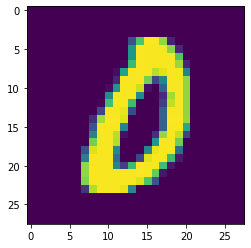

0


In [11]:

# print images
data = get_data(images_raw, labels_raw)
N = get_num_cls(data)
print("Number of classes = ", N)
data_split = int(data[0].shape[0] * 0.75)
images, test_images = data[0][0: data_split], data[0][data_split:]
labels, test_labels = data[1][0: data_split], data[1][data_split:]

print(images.shape)
print(labels.shape)
print(test_images.shape)
print(test_labels.shape)

sort_index = np.argsort(labels, axis=0)

sorted_images = images[sort_index]
sorted_labels = labels[sort_index]

sorted_data = sorted_images, sorted_labels

test_data = test_images, test_labels

image = np.asarray(sorted_images[1]).squeeze()
plt.imshow(image)
plt.show()

print(decoder[sorted_labels[1]])

In [12]:
%%time
np.set_printoptions(threshold=2 ** 10 + 1)
print(sorted_labels)

[0 0 0 ... 9 9 9]
CPU times: user 1.72 ms, sys: 587 µs, total: 2.3 ms
Wall time: 1.82 ms


In [13]:
class AdamOptim():
    """From https://towardsdatascience.com/how-to-implement-an-adam-optimizer-from-scratch-76e7b217f1cc
        each class has its own key for a dict with the respective values in it, this speeds up training but slows down prediction
    """
    def __init__(self, num_of_keys=N, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """Inits the values used in adam"""
        self.m_dw = {key: 0 for key in range(num_of_keys)}
        self.v_dw = {key: 0 for key in range(num_of_keys)}
        self.m_db = {key: 0 for key in range(num_of_keys)}
        self.v_db = {key: 0 for key in range(num_of_keys)}
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, key, t, w, b, dw, db):
        """Updates the values used in the adam optimizer"""
        ## dw, db are from current minibatch
        ## momentum beta 1
        # *** weights *** #
        self.m_dw[key] = self.beta1*self.m_dw[key] + (1-self.beta1)*dw
        # *** biases *** #
        self.m_db[key] = self.beta1*self.m_db[key] + (1-self.beta1)*db

        ## rms beta 2
        # *** weights *** #
        self.v_dw[key] = self.beta2*self.v_dw[key] + (1-self.beta2)*(dw**2)
        # *** biases *** #
        self.v_db[key] = self.beta2*self.v_db[key] + (1-self.beta2)*(db)

        ## bias correction
        m_dw_corr = self.m_dw[key]/(1-self.beta1**t + self.epsilon)
        m_db_corr = self.m_db[key]/(1-self.beta1**t + self.epsilon)
        v_dw_corr = self.v_dw[key]/(1-self.beta2**t + self.epsilon)
        v_db_corr = self.v_db[key]/(1-self.beta2**t + self.epsilon)

        ## update weights and biases
        w = w + self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        b = b + self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon))
        return w, b

In [14]:


class Forward_and_backward:
    """Bassed off of:
        https://arxiv.org/pdf/1908.08385.pdf
        This model uses quantum simulation to train, while it is not currently desined to work on quantum circuits it would only take some
        minor adjustments to make it work. However I do not have access to the arichtechture I need to run classification on. This model needs
        one qubit per class, so task such as binary classification would be very quick.
    """
    def __init__(self, N, data, test_data, num_of_it):
        """Inits values:
            self.num_of_it: number of iterations
            self.target_N: the number of classes
            self.data: the data to classify and train with
            self.test_data: the test data
            self.alpha: a learnable parameter simular to biases
            self.total_error: The total error per class starting with class 0 and ending at class N. Is a dict containing the errors per epoch
            self.set_lie_alge: If true gets a new set of lie algebras if flase saves the current set for calculations
            self.cumulative_error: the cumulative error over iterations
            """
        self.num_of_it = num_of_it
        self.target_N = N
        data_split = int(data[0].shape[0] * 0.75)
        self.data = data
        self.test_data = test_data
        self.alpha = {} # kind of like biases
        self.total_error = {}
        self.set_lie_alge = True
        self.cumulative_error = 0
    
    def H(self):
        """H is a generalized Haadamard gate, in simple terms it distributes the probability of the outcomes evenly"""
        epsilon = 1e-05
        term0 = self.A()
        term1 = self.SU_Nm1
        term2 = np.sum(self.lie_alge)
        term3 = np.sum(self.alpha[self.i] * (1 + 0j))
        term4 = np.exp(1j * term2 * term3) + epsilon
        
        euler = term0 * term1 * term4
        euler = OneQubitEulerDecomposer("ZYZ").angles(euler)
        
        def map_circuit(k, qc_k):
            """This sub function maps all the circuits to eachother entangleing the values, so that when one is measured all respond"""
            for i in range(self.target_N):
                try:
                    qc_k.cx(k, i) @ (np.asarray(euler)[np.newaxis]).T
                except:
                    continue

        qr = QuantumRegister(self.target_N, "qreg")
        qc_k = QuantumCircuit(qr, name="qc_k")
        
        for k in range(1, self.target_N + 1):
            qc_k.initialize([np.sqrt(1/2), np.sqrt(1/2)], qubits=k - 1)
        
        for k in range(self.target_N):
            map_circuit(k, qc_k)

        op = PrimitiveOp(qc_k)
        h = []
        for i in range(self.x.shape[2]):
            h.append(op)
            
        h = np.asarray(h, dtype=object)[:np.newaxis]
        H_op = np.asarray(h / np.sqrt(self.target_N, dtype=np.complex_), dtype=object) 
        
        return H_op
        
    def quNit(self, SU_of_N):
        """A quNit is a quantum uint, similar to how a byte is made up of bits"""
        S3 =np.zeros(shape=(self.target_N, self.target_N), dtype=np.complex_)
        np.fill_diagonal(S3, -(self.target_N - 1) / 2)
        sum_of_weights = np.sum(np.asarray([w @ x for w, x in zip(self.W[self.i], self.x)]), axis=0)
        Z = np.exp((1j) * S3) 

        self.lie_alge = self.lie_algebra(SU_of_N)
        
        qn = Z @ (sum_of_weights @ self.H()).T
        return qn

 ##################################################   

    def A(self):
        """Bassed off of A in the paper https://arxiv.org/pdf/1908.08385.pdf found in formula 3"""
        a = []
        epsilon = 1e-05
        
        for k in range(2, self.target_N + 1):
            term0 = 1j * self.lie_alge[2]
            term1 = self.alpha[self.i][(2 * k - 3) - 1]
            term2 = np.exp(term0 * term1)
            term3 = 1j * self.lie_alge[((k - 1) ** 2 + 1) - 1]
            term4 = self.alpha[self.i][(2 * (k - 1)) - 1]
            term5 = np.exp(term3 * term4)
            term6 = term2 * term5
            val = term6
            a.append(val + epsilon)
        
        return np.prod(a) 
    
    def SU_of_N(self, n):
        """Technicly I am using the special orthogonal group of N instead of the special unitary group of N, but I could not find a modual to calculate
            high dimensonal SU of N so this had to do, overall it will hurt my speed and accuracy some but should still work."""
        son = SpecialOrthogonal(n=n, point_type='matrix')
        metric = son.bi_invariant_metric

        data = son.random_uniform(n_samples=(n))

        tpca = TangentPCA(metric=metric, n_components=(n))  ## SELF.TARGET_N?
        tpca = tpca.fit(data)
        tangent_projected_data = tpca.transform(data)

        return tangent_projected_data

    def lie_algebra(self, SU_N):
        """Some of the lie algebras of the group SO of N, lie algebra deals with the space near the origin of SO of N and plays a cruical role in
            optimizing the model.
        """
        if self.set_lie_alge == True:
            self.set_lie_alge = False
            i = 0
            epsilon = 1e-10
            lie_algebras = []
            while i < self.target_N ** 2:
                # print("working on lie algebra {} / {}".format(i, self.target_N ** 2))
                delta = epsilon * np.random.uniform(low=-10, high=10, size=(1))
                mat = np.full((self.target_N, self.target_N), delta)
                np.fill_diagonal(mat, 0)
                
                if not np.linalg.det(mat) or np.isclose(delta, 0, atol=epsilon):
                    continue
                else:
                    i += 1
                    lie = mat 
                    lie_algebras.append(lie)

            return np.asarray(lie_algebras, dtype= complex)

        else:
            return self.lie_alge
    ############################################
    
    
    def forward(self):
        """The forward step. This takes all of the other parts and ties them together in the forward step. It measures the quantum circuit and returns
            a state vector. It also provides a probability distribution for the values, sometimes the distribution can be off and this can upset the values
            but given enough itterations it corrects over time."""
        SU_N = self.SU_N
        ket_x = self.quNit(SU_N)
        
        ket_x = SU_N @ ket_x

        ket_x_list = []

        for k, op in enumerate(ket_x):
            cr = ClassicalRegister(self.target_N, "creg{}".format(k))
            qc = my_expectation.convert(op)
            qc = qc.to_circuit()
            qc.add_register(cr)
            qc.measure_all([val for val in range(self.target_N - 1)])
            qobj = assemble(qc, shots= 2 ** self.target_N)
            job = simulator.run(qobj)
            vec = job.result().get_statevector(qc, decimals=10)
            ket_x_list.append(vec)
        
        ket_x = np.asarray(ket_x_list)

        def Purity(N, ket_x):
            """This measures the purity of the quantum circuits it is used to deterimine how accurate the probabilities are."""
            bra_x = np.asmatrix(ket_x).H
            
            return ((ket_x @ bra_x) / N) ** 2
            
        Pa = Purity(self.target_N, ket_x)
        Pa = np.diag(Pa)
        Pb = np.argmax(Pa)
        print("probibility distiribution = ", Pa.real)

        return Pb, ket_x

    def backward(self, pred_dict):
        """This is the back propagation step, to some degree along with the loss function."""
        SU_N = self.SU_N
        qc = self.H()
        Mk = self.target_N
        
        ket_x = pred_dict[decoder[self.i]][1]
        
        Pk = np.sum((np.matrix(ket_x) @ np.matrix(ket_x).H)  / Mk)
        
        Pk = np.asarray(np.asmatrix(SU_N) * Pk * np.asmatrix(SU_N).H, dtype=np.complex_)
        Pk = np.diagonal(Pk.real)

        self.total_error[self.i] = (1 - Pk) / Mk
        
        self.cumulative_error = (Pk) / (self.j + 1) + (self.cumulative_error * 0.9) # 0.9 is a decay rate
        
        for i, value in enumerate(self.cumulative_error):
            print("Total error of {} = {}".format(i, (value)))
        print("Prediction for class = ", np.argmax(self.cumulative_error))
        
    def train(self):
        """This is the primary driver for training the quantum circuits, there are some safety percautions built in to handle the rare occuracne of
            numerical instability. It uses an adam optimizer, and takes a foward and backward step per iteration. In this model each epoch is one class
            and the iterations are how many times the class is run through the quantum circuit.
        """
        adam = AdamOptim(num_of_keys=self.target_N)
        pred_dict = {}
        init_W = True
        sums_of_errors = []
        self.W = {}
        self.SU_N = self.SU_of_N(self.target_N)
        self.SU_Nm1 = self.SU_of_N(self.target_N - 1)
        
        i = 0
        j = 0
        
        sorted_images = self.data[0].squeeze(axis=(-1))
        print(sorted_images.shape)
        sorted_labels = self.data[1]
        
        for i in range(self.target_N):
            try_count = 0
            self.i = i
            init_W = True
            self.alpha[self.i] = np.arange(start=1, stop=self.target_N ** 2 + 1, dtype=np.complex_)
            
            y = sorted_labels[sorted_labels == i]
            self.x = sorted_images[sorted_labels == i]
            print(self.x.shape)
            
            while j < self.num_of_it:
                print("working on {}s".format(decoder[i]))
                print("iteration {} / {}".format(j + 1, self.num_of_it))
                try:
                    self.j = j
                    if init_W:
                        print("init W")
                        self.W[self.i] = np.random.random(size=(self.x.shape[0], self.target_N, self.x.shape[2])) # learnable similar to weights

                    pred_dict[decoder[i]] = self.forward()
                    self.backward(pred_dict)

                    dw = (np.asarray([w @ w.T for w in self.W[self.i]], dtype=np.complex_) @ self.total_error[self.i])[:, :, np.newaxis]
                    db = self.alpha[self.i]  @ self.alpha[self.i].T * np.sum(self.total_error[self.i])

                    self.W[self.i], self.alpha[self.i] = adam.update(key=i, t=j, w=self.W[self.i], b=self.alpha[self.i], dw=dw, db=db)

                    init_W = False

                    j += 1
                except(ValueError) as e:
                    print("==========Numerical instability occured retrying calculations==========")
                    print("==========Calculations retried {} / 10 times==========".format(try_count + 1))
                    print(e)
                    try_count += 1
                    self.set_lie_alge = True
                    if try_count == 10:
                        print("==========Major error occured rerun program==========")
                        return 1
            sums_of_errors.append(self.cumulative_error)
            self.cumulative_error = 0
            j = 0
            
    def predict(self):
        """Uses a stripped down version of train to make predictions. For each image in question it will go through all of the classes and determine a
           likely hood of the image belonging to the class."""
        self.SU_N = self.SU_of_N(self.target_N)
        self.SU_Nm1 = self.SU_of_N(self.target_N - 1)
        pred_dict = {}
        sums_of_errors = []
        
        i = 0
        j = 0
        
        images = self.test_data[0].squeeze(axis=(-1))
        self.labels = test_data[1]
        print(sorted_images.shape)
        sorted_labels = self.data[1]
        for k, value in enumerate(images):
            self.x = value
            print(sorted_labels[k])
            for i in range(self.target_N):
                try_count = 0
                self.i = i
                self.x = images

                while j < 1:
                    try:
                        self.j = j

                        pred_dict[decoder[i]] = self.forward()
                        self.backward(pred_dict)

                        j += 1
                    except(ValueError) as e:
                        print("==========Numerical instability occured retrying calculations==========")
                        print("==========Calculations retried {} / 10 times==========".format(try_count + 1))
                        print(e)
                        try_count += 1

                        if try_count == 10:
                            print("==========Major error occured rerun program==========")
                            return 1
                sums_of_errors.append(self.cumulative_error)
                self.cumulative_error = 0
                j = 0
            

In [15]:
%%time
train = Forward_and_backward(N, sorted_data, test_data, 50)

CPU times: user 12 µs, sys: 4 µs, total: 16 µs
Wall time: 21.2 µs


In [ ]:
%%time
train.train()

(6144, 28, 28)
(606, 28, 28)
working on 0s
iteration 1 / 50
init W


In [ ]:
%%time
train.predict()